# IBM Dynamical Decoupling Optimizations with Superstaq - Strategies

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_dd.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_dd.ipynb)

There are many possible ways to determine how and where to place DD sequences within an idling window. We refer to these approaches as strategies. If users want more control over the way Superstaq applies DD, they can specify their desired strategy. Superstaq supports the following dynamical decoupling strategies:

* **Standard**: Places a single DD sequence in each idle window.<br>
* **Syncopated**: Places DD pulses at fixed time intervals, alternating between pulses on neighboring qubits in order to mitigate parasitic ZZ coupling errors.<br>
* **Adaptive** (default): Dynamically spaces DD pulses across idle windows with awareness of neighboring qubits to achieve the parasitic ZZ coupling mitigation of the "syncopated" strategy with fewer pulses and less discretization error.<br>

Users have the ability to specify the dynamical decoupling strategy desired via the keyword argument `dd_strategy`.

All of the above strategies, by default, use the XX sequence: a sequence consisting of a pair of equally-spaced X gates. this can be changed via the `dd_sequence` keyword argument.

## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit; you can try it out by running `pip install qiskit-superstaq`.

In [ ]:
# Required Superstaq imports
try:
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")

    import qiskit_superstaq as qss

import qiskit

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API)).

In [2]:
# Get the qiskit superstaq provider for Superstaq backend
# Provide your api key to the using the "api_key" argument if the SUPERSTAQ_API_KEY environment variable is not set.
provider = qss.SuperstaqProvider()

This notebook will target IBM's 127-qubit Brisbane device.

In [3]:
backend = provider.get_backend("ibmq_brisbane_qpu")

## Example 1: Circuit Compilation and DD Optimization with Superstaq

In this example, we will be creating a pair of 8-qubit GHZ circuits, which we generate below:

In [4]:
n_qubits = 8
circuit = qiskit.QuantumCircuit(8)

circuit.h(0)
for i in range(1, circuit.num_qubits):
    circuit.cx(0, i)

for i in range(circuit.num_qubits - 1):
    circuit.cx(-1, i)

circuit.measure_all()

We can draw the circuit using `qiskit`:

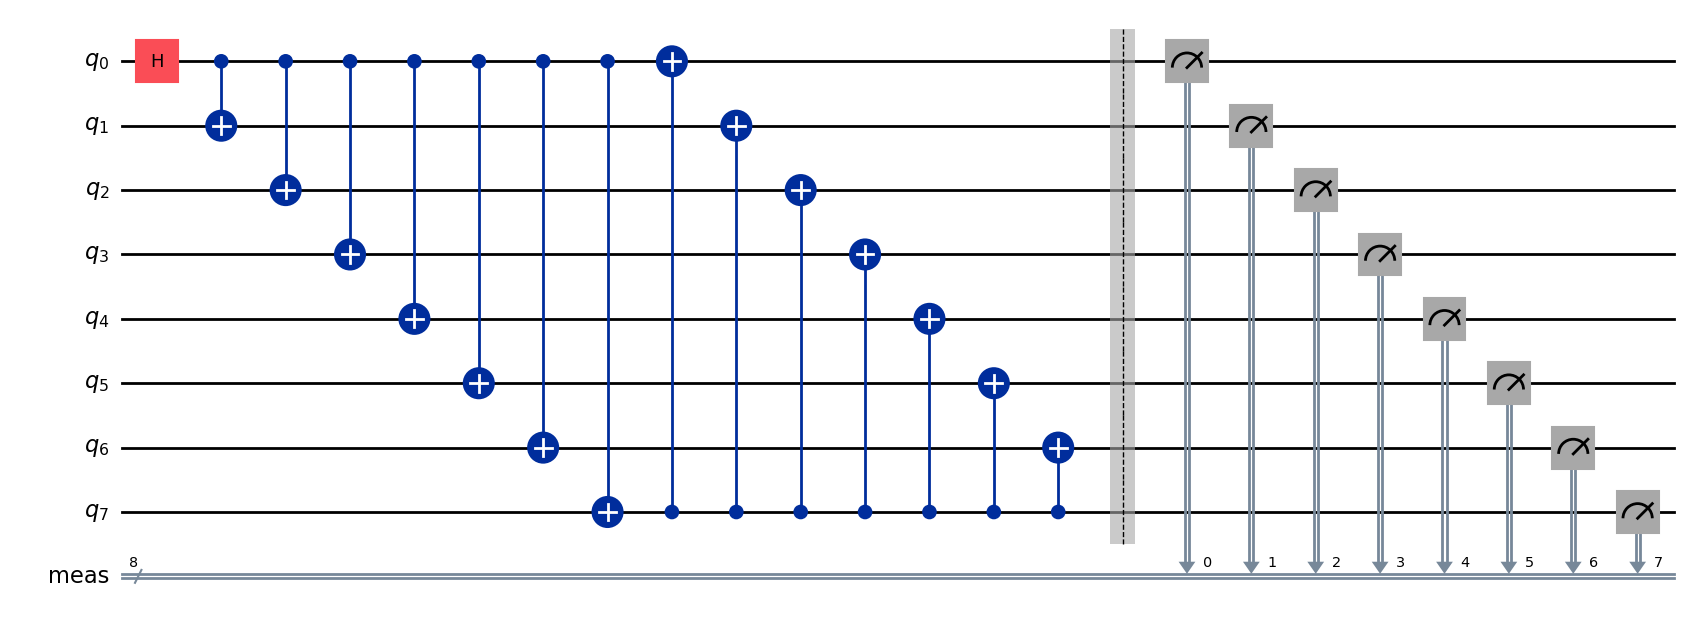

In [5]:
circuit.draw("mpl")

First, we'll use Superstaq to compile and optimize the logical circuit with no dynamical decoupling, as a baseline. Passing a random seed here helps ensure we can easily compare the compiled circuit to those we generate in subsequent cells, despite any stochasticity in the compiler.

In [6]:
compiler_output = backend.compile(circuit, dynamical_decoupling=False, random_seed=123)

Qiskit's timeline drawer now allows us to observe the gates and gate times in the compiled circuit.

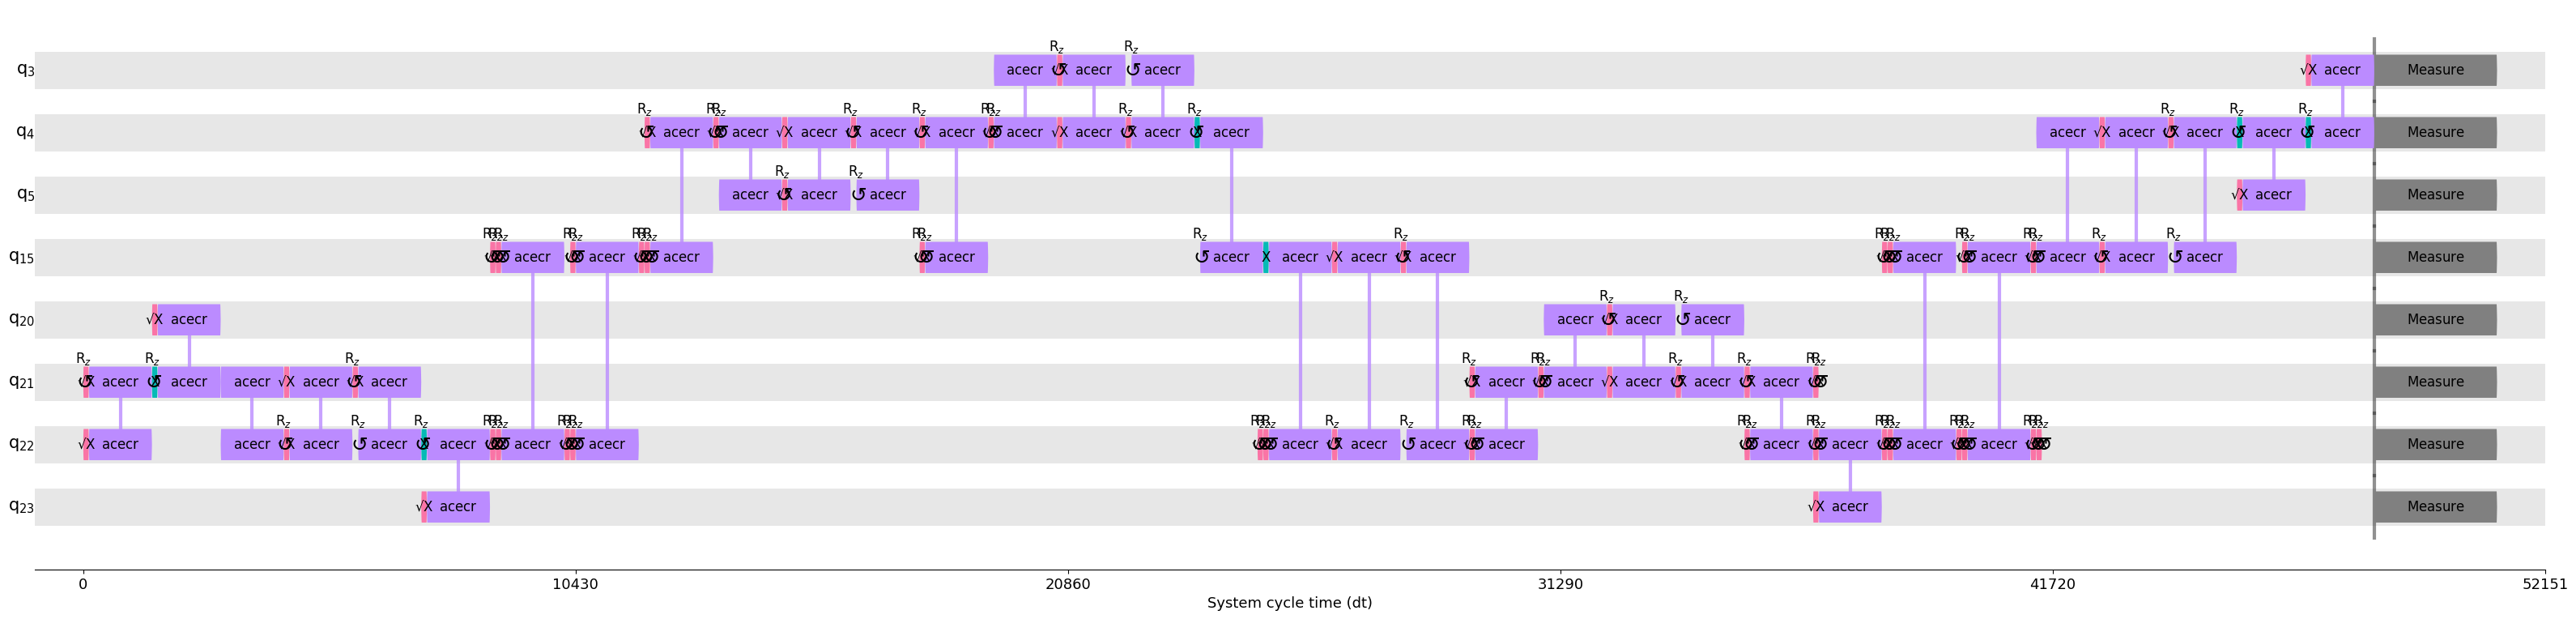

In [7]:
custom_style = {"formatter.general.fig_width": 40, "formatter.general.fig_unit_height": 1}
style = qiskit.visualization.timeline.IQXStandard(**custom_style)

qiskit.visualization.timeline_drawer(
    compiler_output.pulse_gate_circuit, idle_wires=False, style=style
)

Next we'll compile the same circuit using the "standard" dynamical decoupling strategy. This strategy inserts pairs of X gates into the long idle periods on each qubit in order to suppress local dephasing.

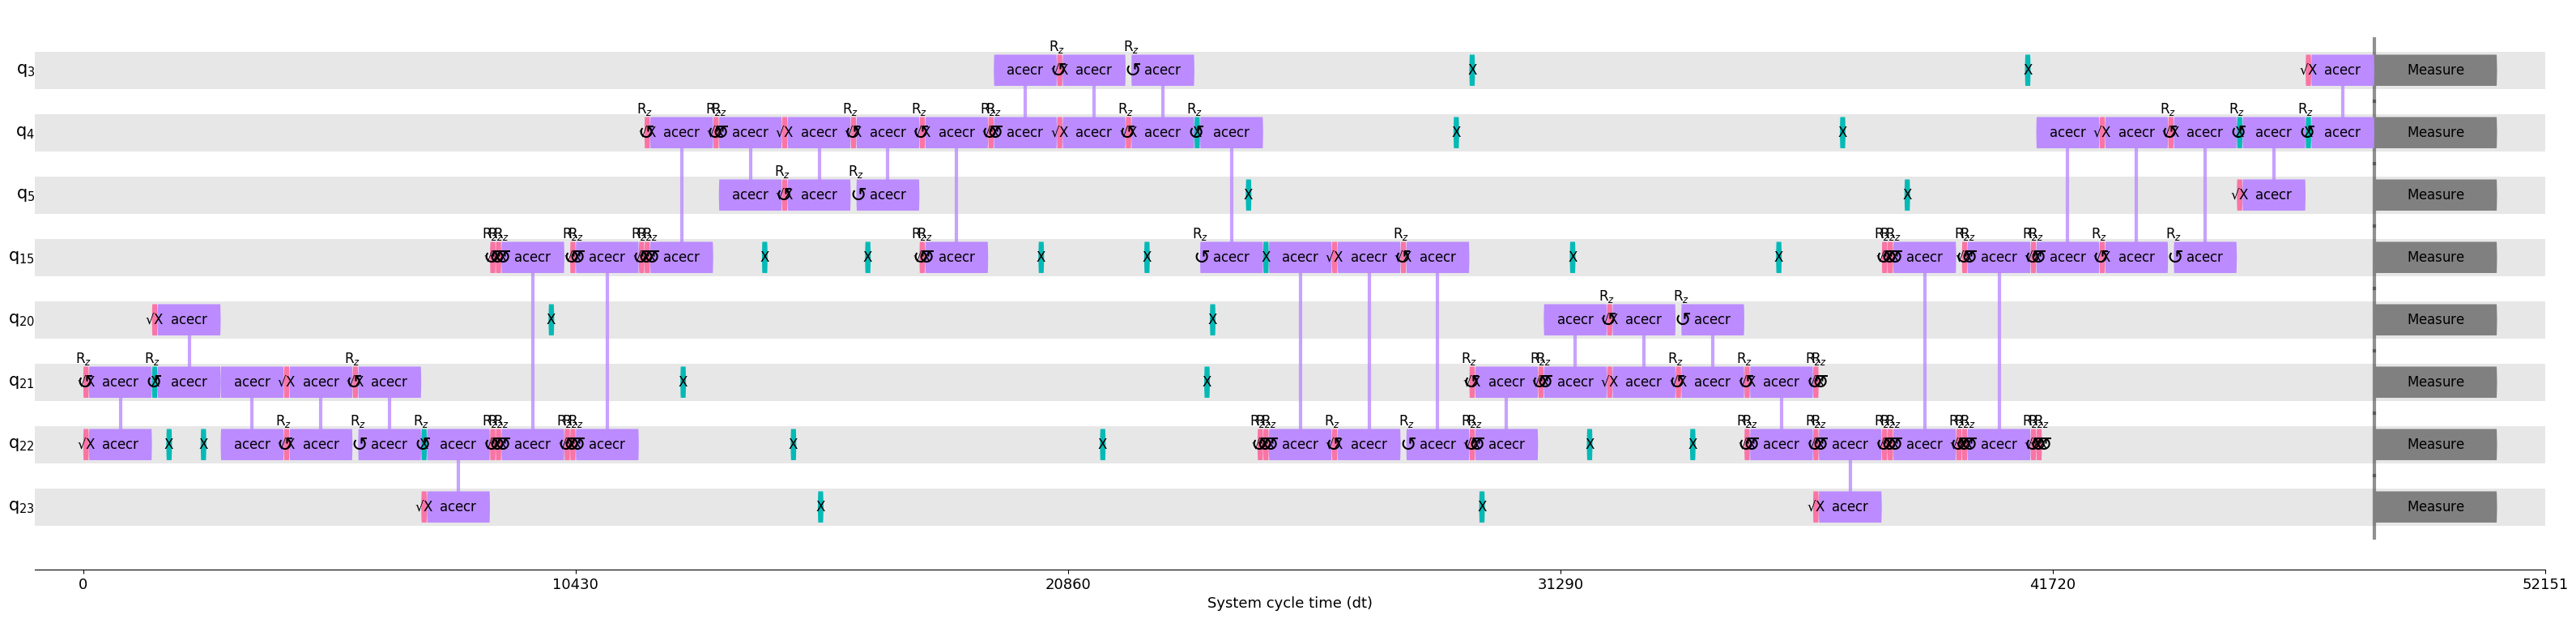

In [8]:
compiler_output = backend.compile(
    circuit, dd_strategy="standard", dynamical_decoupling=True, random_seed=123
)

qiskit.visualization.timeline_drawer(
    compiler_output.pulse_gate_circuit, idle_wires=False, style=style
)

Below, we compile with dynamical decoupling using the "syncopated" strategy. With this strategy many equally-spaced DD pulses can be inserted into the same idle period. Their timing relative to those on neighboring qubits can suppress errors due to parasitic coupling in adition to local dephasing.

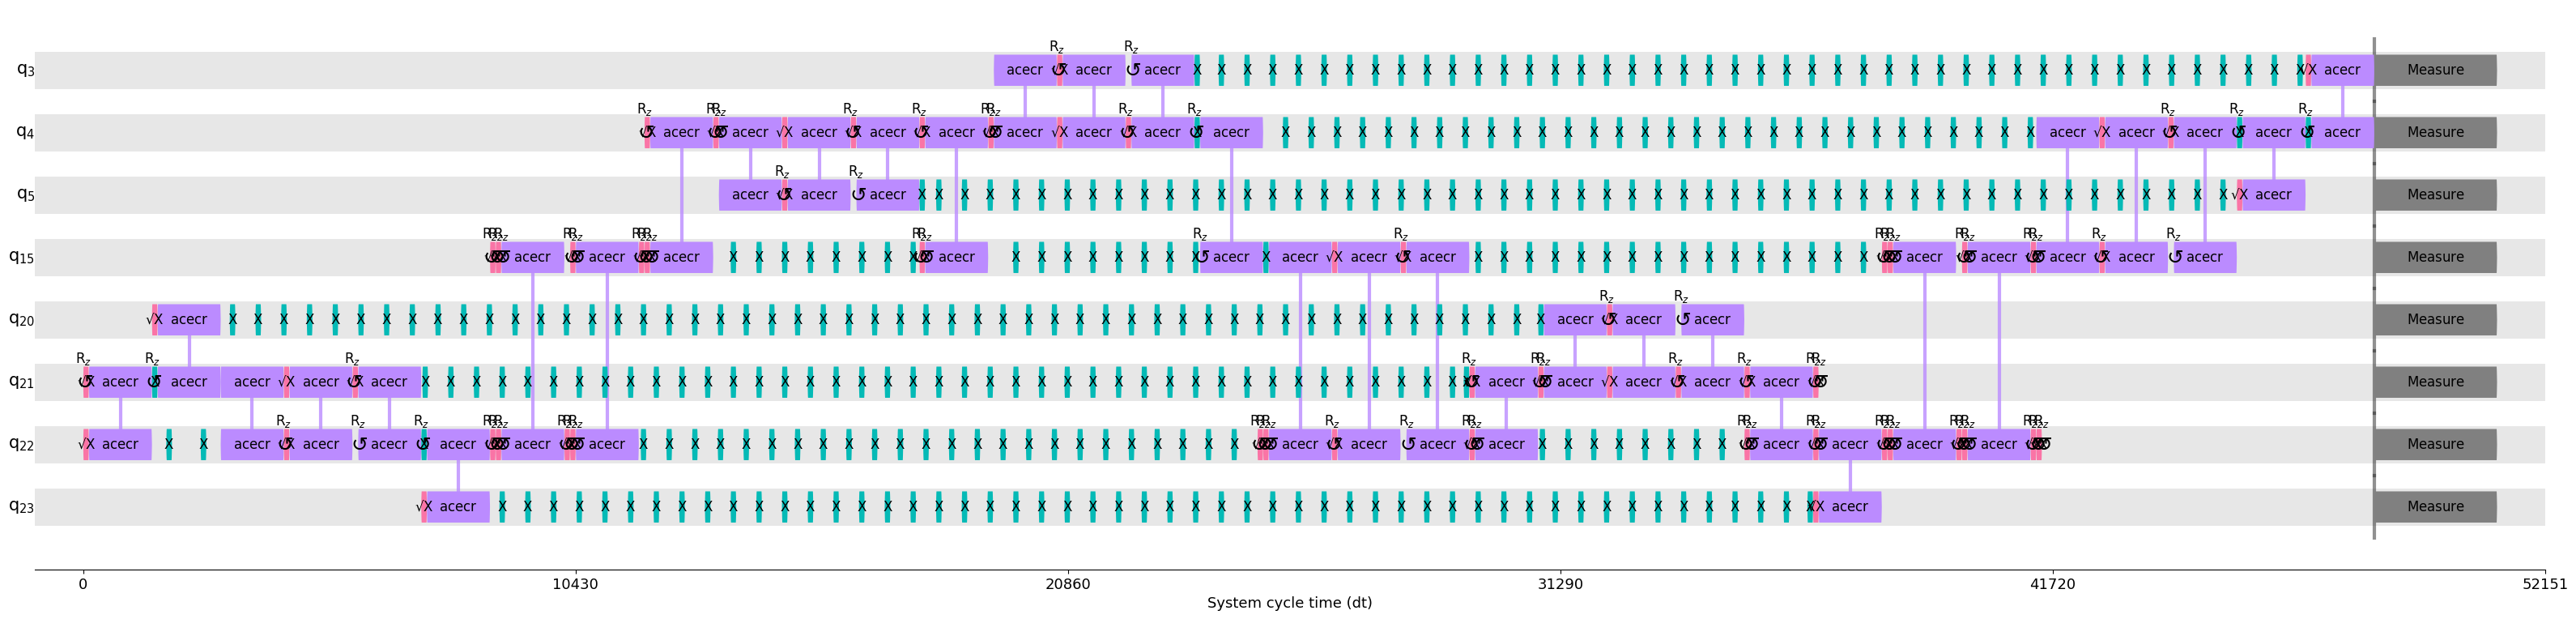

In [9]:
compiler_output = backend.compile(
    circuit, dd_strategy="syncopated", dynamical_decoupling=True, random_seed=123
)

qiskit.visualization.timeline_drawer(
    compiler_output.pulse_gate_circuit, idle_wires=False, style=style
)

Finally, we compile with dynamical decoupling using Superstaq's default "adaptive" strategy. This will adaptively space DD pulses in order to achieve the error suppression of the prior strategy with far fewer pulses.

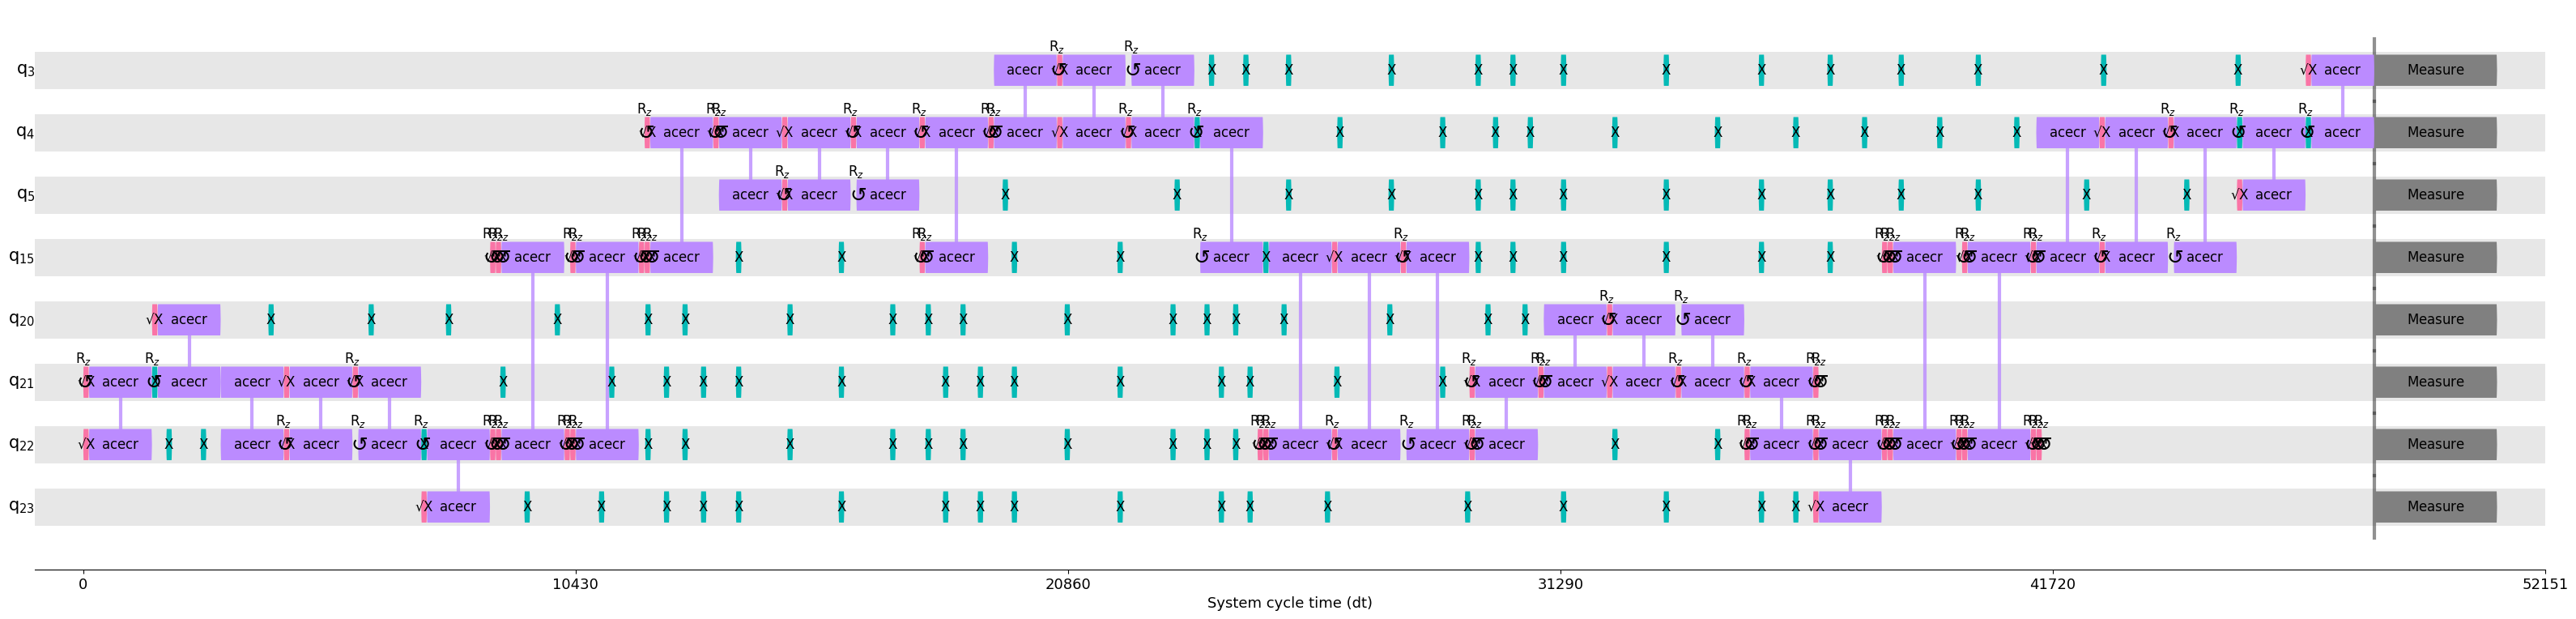

In [10]:
compiler_output = backend.compile(
    circuit, dd_strategy="adaptive", dynamical_decoupling=True, random_seed=123
)

qiskit.visualization.timeline_drawer(
    compiler_output.pulse_gate_circuit, idle_wires=False, style=style
)